# Real or Not? Disaster Tweets Classifications

In [2]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download Data

In [3]:
tweet = pd.read_csv('twitter-disaster-prediction-dataset/master/train.csv')

In [4]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweet.shape

(7613, 5)

In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [12]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

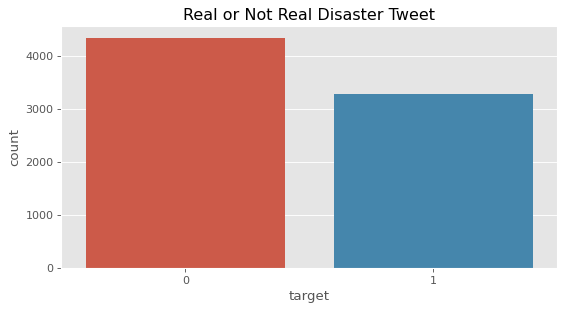

In [13]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [14]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

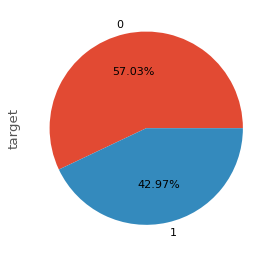

In [16]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [17]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-sotssqch
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-sotssqch
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.0-cp36-none-any.whl size=11716 sha256=a038ed05c0f2f4edc25b9de3c35f0b594f4e1084b764546438509ee4fbcd44a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-p8ihydft/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [18]:
import preprocess_kgptalkie as kgp

In [20]:
tweet = kgp.get_basic_features(tweet)

In [21]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


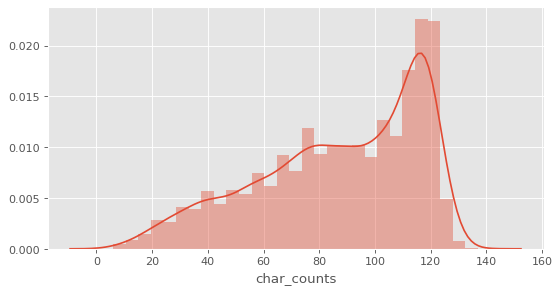

In [22]:
sns.distplot(tweet['char_counts'])

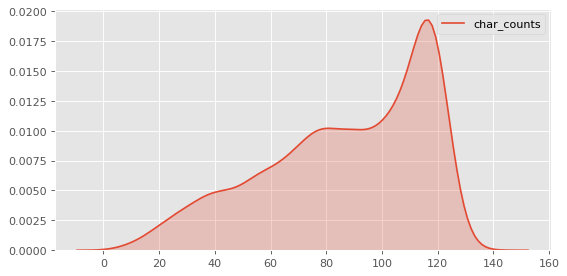

In [24]:
sns.kdeplot(tweet['char_counts'], shade=True)

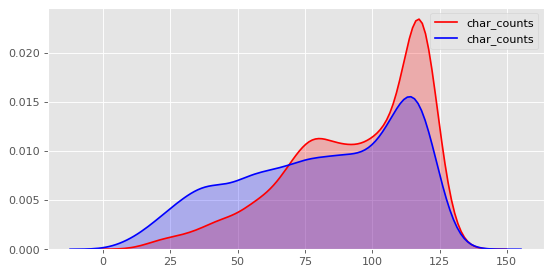

In [32]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

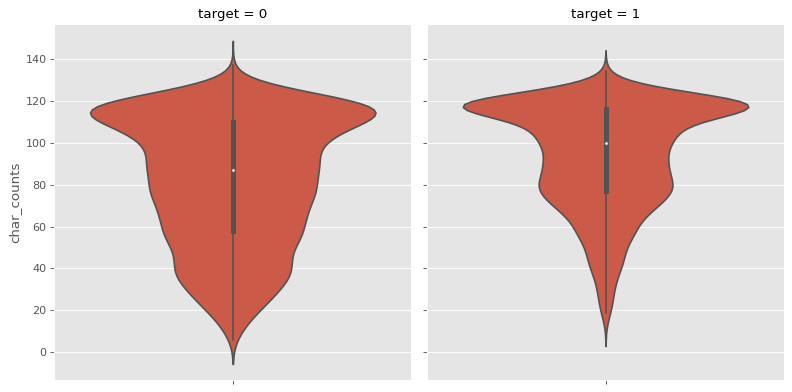

In [27]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

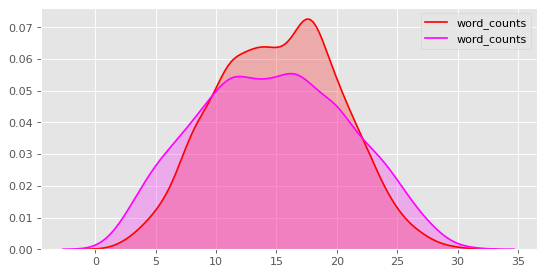

In [36]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


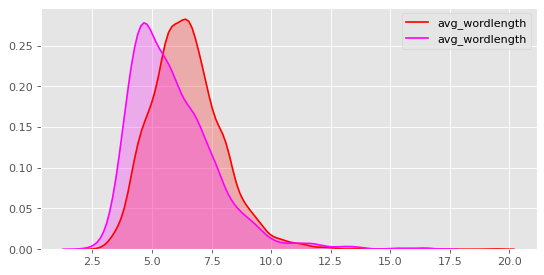

In [37]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


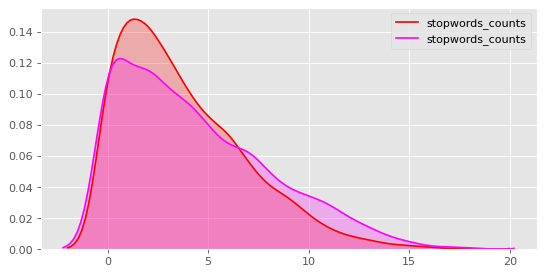

In [41]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [40]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [43]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [46]:
top20 = freqs[100:120]

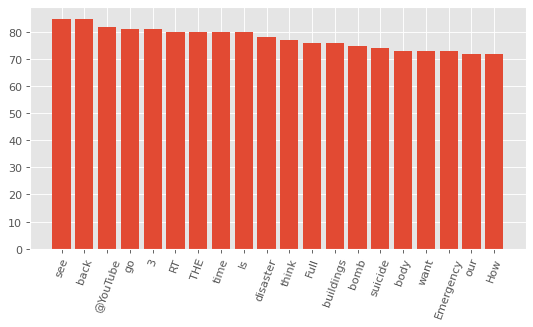

In [49]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [50]:
least20 = freqs[-20:]
least20

BOMBER                    1
Chachi...                 1
#News:                    1
unfilled                  1
jay....big                1
re-opens                  1
@MariahCarey              1
Whales                    1
http://t.co/8kjS7ZqAjS    1
@adndotcom                1
Q13                       1
Siren's                   1
failing                   1
@Adanne___                1
lambasts                  1
joked                     1
@Shayoly                  1
http://t.co/WlmSQ3MTHO    1
ÛÏ@LeoBlakeCarter:       1
endangered                1
dtype: int64

In [51]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [54]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

### One-Shot Data Cleaning

In [55]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [56]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [58]:
tweet.head()['text']

0    oyour deeds are the reason of this earetweethq...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evasee yoyouation...
4    jyoust got sent this photo from ryouby alaska ...
Name: text, dtype: object

In [60]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

### Disaster Words Visualization with Word Cloud



In [64]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'heighttpt the in a of to and is i on for see at iss by from it that with not yoyou afeatyouringer this fire are was se as have my over news heighttpostscripointt youp more via thisaster an were be poli get syoui seeide california has no people evasee who minister do byout when so been intelligence like killed oyout jyoust will 2 hiroshima love than fires storm crash familthat we now train offi into ressee aaboyout s emergency yoyour bomb byouildings there all am two what mh370 attack nyouclear they time video wildfire new accident eyouropean prime learnedl one bombing noretweethern how byourning lexampleionnaires dead good me bomber pi homes some if you today car back atomi war stoday real obama isd fatal he years off collapostscripointe may forest seeal debris watch city japan malaysia yous 1 first retweet man or mass latest water near severe had confirmed earetweethqyouake thoyoughse sentral foyound life oil dthat floods world 70 spill down army apagesli servi younder home warning t

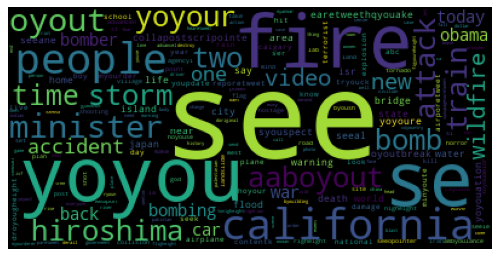

In [65]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

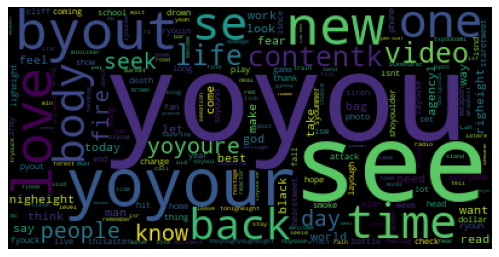

In [67]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [68]:
text = tweet['text']
y = tweet['target']

In [69]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [70]:
X.shape

(7613, 23333)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [79]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [80]:
from sklearn.svm import LinearSVC

In [81]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



## Classification with `Word2Vec` and SVM


In [83]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=743afd15a022211ce3572f19a4ff7b877f7ab28b325752a85241bf7725d7d63b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ucsfrmvu/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [84]:
import spacy
import en_core_web_lg

In [85]:
nlp = en_core_web_lg.load()

In [86]:
x = 'cat dog'
doc = nlp(x)

In [87]:
doc.vector.shape

(300,)

In [88]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [89]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [90]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,oyour deeds are the reason of this earetweethq...,1,57,13,4.384615,6,1,0,0,1,"[-0.2098871, -0.007629695, -0.19607861, -0.163..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-0.00050089136, 0.023181401, -0.102390535, -0..."
3,6,NaN,NaN,130 people receive wildfires evasee yoyouation...,1,57,8,7.125000,1,1,0,1,0,"[-0.14550035, 0.21902388, 0.07671245, -0.14768..."
4,7,NaN,NaN,jyoust got sent this photo from ryouby alaska ...,1,72,16,4.500000,6,2,0,0,0,"[-0.0026213732, -0.01916919, -0.063435, 0.0685..."


In [91]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [93]:
X.shape

(7613, 1)

In [95]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [96]:
X.shape

(7613, 300)

In [97]:
y = tweet['target']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [99]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       869
           1       0.78      0.68      0.73       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

CPU times: user 2.85 s, sys: 18.8 ms, total: 2.86 s
Wall time: 2.86 s


## Word Embeddings and Classification with Deep Learning


In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [103]:
text

0       oyour deeds are the reason of this earetweethq...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evasee yoyouation...
4       jyoust got sent this photo from ryouby alaska ...
                              ...                        
7608    two giant cranes holding a bridge collapostscr...
7609    aria ahoyourary thetawnice to haveat isst the ...
7610    m1 94 0104 yocoordinated universal time5km s o...
7611    poli se investigating afeatyouringer an ebike ...
7612    the latest more homes razed by noretweethern c...
Name: text, Length: 7613, dtype: object

In [102]:
token = Tokenizer()
token.fit_on_texts(text)

In [104]:
vocab_size = len(token.word_index) + 1
vocab_size

23370

In [105]:
print(token.word_index)

{'heighttpt': 1, 'the': 2, 'a': 3, 'to': 4, 'in': 5, 'i': 6, 'of': 7, 'is': 8, 'and': 9, 'yoyou': 10, 'for': 11, 'on': 12, 'see': 13, 'my': 14, 'it': 15, 'not': 16, 'that': 17, 'with': 18, 'at': 19, 'by': 20, 'iss': 21, 'this': 22, 'have': 23, 'are': 24, 'from': 25, 'be': 26, 'was': 27, 'heighttpostscripointt': 28, 'so': 29, 'do': 30, 'get': 31, 'oyout': 32, 'like': 33, 'as': 34, 'am': 35, 'youp': 36, 'jyoust': 37, 'me': 38, 'byout': 39, 'yoyour': 40, 'will': 41, 'se': 42, 'over': 43, 'has': 44, 'all': 45, 'afeatyouringer': 46, 'no': 47, 'fire': 48, 'an': 49, 'love': 50, 'when': 51, 'new': 52, 'if': 53, 'he': 54, 'we': 55, 'they': 56, 'now': 57, 'via': 58, 'more': 59, 'aaboyout': 60, 'what': 61, 'intelligence': 62, 'or': 63, 'time': 64, 'people': 65, 'how': 66, 'one': 67, 'been': 68, 'there': 69, '2': 70, 'news': 71, 'back': 72, 'who': 73, 'poli': 74, 'good': 75, 'into': 76, 'real': 77, 'were': 78, 'video': 79, 'eyouropean': 80, 'can': 81, 'emergency': 82, 'thisaster': 83, 'learnedl': 

In [106]:
encoded_text = token.texts_to_sequences(text)

In [107]:
print(encoded_text)

[[129, 4714, 24, 2, 966, 7, 22, 291, 150, 1820, 4715, 96, 45], [214, 48, 261, 858, 7056, 7057, 1454], [45, 1821, 1455, 4, 2220, 5, 741, 24, 146, 7058, 134, 20, 111, 1822, 47, 476, 90, 300, 63, 2220, 5, 741, 1456, 24, 1161], [2974, 65, 4716, 1457, 90, 300, 1456, 5, 102], [37, 109, 1221, 22, 367, 25, 7059, 2221, 34, 309, 25, 1457, 7060, 76, 3, 216], [268, 2975, 452, 102, 1687, 889, 926, 5, 722, 7061, 604, 4, 1222, 430, 48, 4717, 1457], [262, 83, 927, 332, 1286, 890, 292, 7, 530, 80, 159, 5, 7062, 1106, 2504, 1688], [6, 35, 12, 263, 7, 2, 2012, 9, 6, 81, 13, 3, 48, 5, 2, 4718], [69, 8, 49, 82, 90, 300, 156, 1365, 57, 5, 2, 666, 928, 2, 530, 80, 64], [6, 35, 2505, 17, 2, 553, 8, 283, 4, 129, 409], [667, 65, 168, 134, 25, 2, 333, 531, 29, 692], [929, 693, 2976, 8, 252, 2977, 3662, 742, 3, 743, 6, 232, 5, 693, 2976, 61, 35, 6, 354, 30, 61, 35, 6, 354, 30, 7063, 292], [2978, 292, 2222, 7064, 2976, 1574, 63, 2013, 694, 6, 23, 825, 3663], [262, 5, 4719, 1006, 55, 1823, 4719], [284, 4, 216, 453,

In [108]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [109]:
print(X)

[[ 129 4714   24 ...    0    0    0]
 [ 214   48  261 ...    0    0    0]
 [  45 1821 1455 ...    0    0    0]
 ...
 [2871 2451 4705 ...    0    0    0]
 [  74   42 1205 ...    0    0    0]
 [   2  239   59 ...    0    0    0]]


In [110]:
X.shape

(7613, 40)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [113]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [114]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [115]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2337000   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [116]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 5s 25ms/step - loss: 0.6712 - accuracy: 0.5780 - val_loss: 0.6324 - val_accuracy: 0.7072
Epoch 2/5
191/191 [==============================] - 5s 25ms/step - loss: 0.5369 - accuracy: 0.7594 - val_loss: 0.4786 - val_accuracy: 0.7938
Epoch 3/5
191/191 [==============================] - 5s 24ms/step - loss: 0.3793 - accuracy: 0.8460 - val_loss: 0.4738 - val_accuracy: 0.7787
Epoch 4/5
191/191 [==============================] - 5s 24ms/step - loss: 0.2579 - accuracy: 0.9053 - val_loss: 0.4895 - val_accuracy: 0.7741
Epoch 5/5
191/191 [==============================] - 5s 24ms/step - loss: 0.1606 - accuracy: 0.9415 - val_loss: 0.5375 - val_accuracy: 0.7781
CPU times: user 38.3 s, sys: 2.22 s, total: 40.5 s
Wall time: 30.6 s


In [135]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [136]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [137]:
vec

array([[ 6, 35,  4, 13, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [138]:
np.argmax(model.predict(vec), axis = -1)

array([0])